# GIA - APRNS - Sesión: Flujos




<font color="red" size=6>
Ejercicio de laboratorio entregable
</font>

---




> - Obten los datos del Olivetti Faces
- Aplica un PCA para obtener un nuevo conjunto de datos de dimensionalidad reducida donde la varianza explicada por los componentes principales sea alrededor del 90% (haz que sea una potencia de 2).
- Transforma los datos y crea con ellos un data loader
- Ajusta un flujo RealNVP como el que hemos hecho para los digitos
- Genera una muestra de los datos
- Calcula la log probabilidad de un subconjunto de los datos
- Haz una interpolacion entre dos de los ejemplos del conjunto de datos real para clases diferentes
- <font color="blue"> Haz un informe comentando lo que has hecho y explica las conclusiones que has sacado</font>

<font color="red"> Nota:</font> No esperes que la generación sea perfecta, no uses un tamaño de batch muy grande (solo hay 400 ejemplos), ten cuidado tambien al seleccionar la tasa de aprendizaje su decaimiento. Ten paciencia, tarda un rato.

In [2]:
# Imports
#!pip install normflows
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import DataLoader, TensorDataset
import normflows as nf
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.optim import lr_scheduler

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


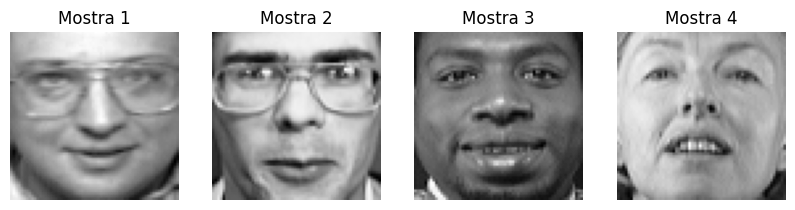

In [3]:
# Carreguem les dades de Olivietti faces
data = fetch_olivetti_faces()
X = data.images.reshape(data.images.shape[0], -1)  # (n_mostres, n_features)

# Visualitzar algunes mostres
n_mostres = 4

plt.figure(figsize=(10, 3))
for i in range(n_mostres):
    plt.subplot(1, n_mostres, i + 1)
    plt.imshow(data.images[np.random.randint(0, 400)], cmap='gray')
    plt.axis('off')
    plt.title(f'Mostra {i + 1}')

plt.show()


Nombre de components:  66


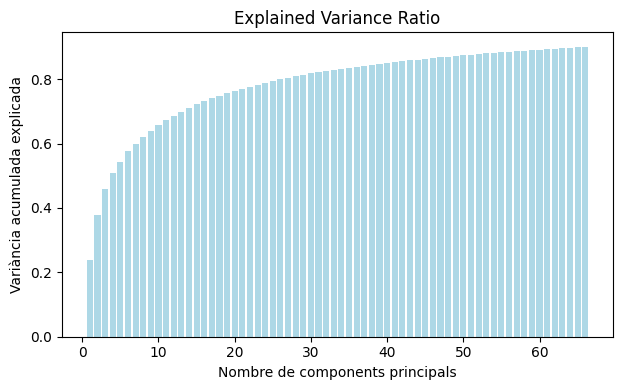

In [4]:
# Apliquem una PCA para fer una reducció de dimensionalitat
pca = PCA(n_components=0.90, svd_solver='full')
X_pca = pca.fit_transform(X)
n_components = pca.n_components_
print('Nombre de components: ', n_components)

# Gràfic de l'explicació de la variància
# Visualitzar els gràfics de PCA
plt.figure(figsize=(12, 4))

# Gràfic de l'explicació de la variància
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), color= 'lightblue')
plt.xlabel('Nombre de components principals')
plt.ylabel('Variància acumulada explicada')
plt.title('Explained Variance Ratio')

plt.tight_layout()
plt.show()

Nº components mes propera potència de dos:  64


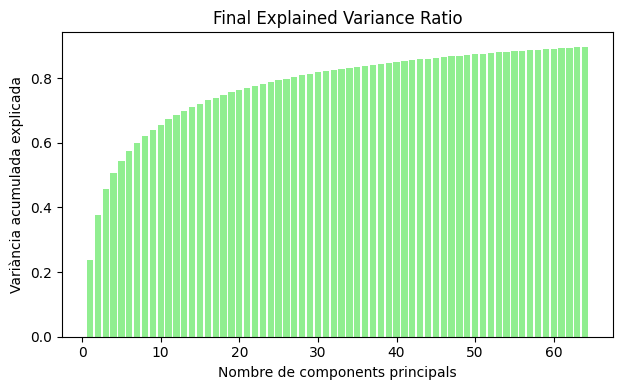

In [5]:
# Ha de ser una potencia de dos per tant:
closest_power_of_2 = 2**round(np.log2(n_components))

print('Nº components mes propera potència de dos: ', closest_power_of_2)

pca = PCA(n_components=closest_power_of_2)
X_pca = pca.fit_transform(X)

# Gràfic de l'explicació de la variància
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), color= 'lightgreen')
plt.xlabel('Nombre de components principals')
plt.ylabel('Variància acumulada explicada')
plt.title('Final Explained Variance Ratio')

plt.tight_layout()
plt.show()

In [6]:
# Creem un dataloader
tensor_x = torch.tensor(X_pca).float()
dataset = TensorDataset(tensor_x)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# config de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Definició del flux RealNVP
K = 8
latent_size = closest_power_of_2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)]).to(device)
flows = []

for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

base = nf.distributions.DiagGaussian(latent_size)
rnvp = nf.NormalizingFlow(base, flows).to(device)

# Bucle d'entrenament per als diferents models
def train_loop(model, optimizer, scheduler, dataloader, epochs, conditional=False):
    hist_loss = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        running_loss = 0.0
        for i, (data,) in enumerate(dataloader):  # Assegurem que desempaquetem les dades correctament
            optimizer.zero_grad()
            data = data.to(device)
            # Calcula la pèrdua depenent de si és condicional o no
            if not conditional:
                loss = model.forward_kld(data)

            # Si la pèrdua no és nan o inf, fa el backpropagation
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

        if scheduler is not None:
            scheduler.step()
            lr = f'lr: {scheduler.get_last_lr()[0]:.4E}'
        else:
            lr = ''

        hist_loss.append(running_loss / i)
        pbar.set_description(f'loss: {running_loss / i:3.4f}:{lr}')

    return hist_loss

loss: 47.4785:lr: 2.1768E-07: 100%|██████████| 150/150 [00:41<00:00,  3.62it/s]


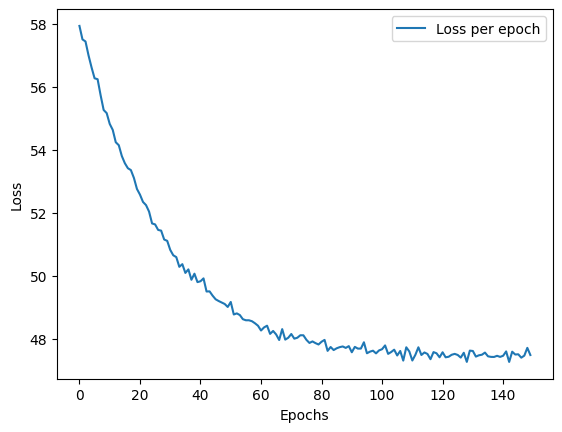

In [25]:
# Iniciem i entrenem
optimizer = torch.optim.Adam(rnvp.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.6)
epochs = 150

hist_loss = train_loop(rnvp, optimizer, scheduler, dataloader, epochs)

# Gràfic de l'histograma de la loss per epoch
plt.plot(hist_loss, label='Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

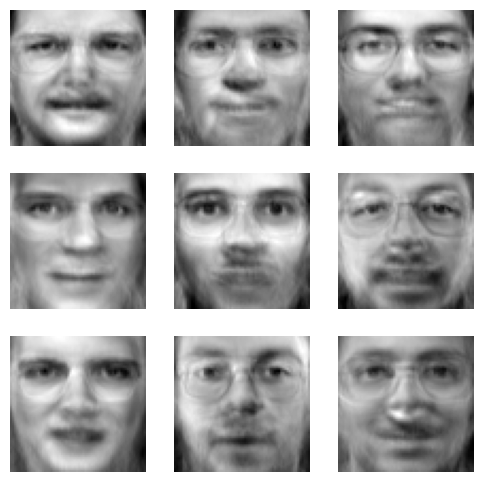

In [29]:
# Ens guardem el estat del model
torch.save(rnvp.state_dict(), './rnvp_olivetti_faces.pt')

lrnvp = nf.NormalizingFlow(base, flows).to(device)
lrnvp.load_state_dict(torch.load('./rnvp_olivetti_faces.pt'))

# Generem mostres i les visualitzem
nim = 3
samples, _ = lrnvp.sample(num_samples=nim * nim)
samples = samples.cpu().detach().numpy()

# Reescalem les mostres utilitzant un PCA invers
fig = plt.figure(figsize=(6, 6))
for i in range(nim * nim):
    plt.subplot(nim, nim, i + 1)
    sample_img = pca.inverse_transform(samples[i]).reshape(64, 64)
    plt.imshow(sample_img, cmap='gray')
    plt.axis('off')

In [30]:
# Calcul de la log prbabilitat de les mostres generades
subset_samples = samples[:16]
subset_samples = torch.tensor(subset_samples, device=device)
log_prob_subset = lrnvp.log_prob(subset_samples)

print("Log Probabilitat del Subconjunt:")
print(log_prob_subset)

Log Probabilitat del Subconjunt:
tensor([-52.5812, -50.4198, -47.0275, -42.1056, -44.4933, -50.1072, -28.1051,
        -40.3816, -49.7897], device='cuda:0', grad_fn=<AddBackward0>)


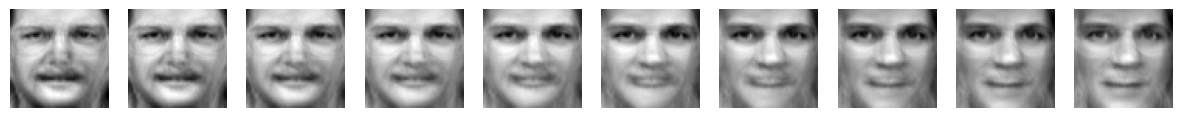

In [32]:
# Interpolació entre dues mostres
d1, d2 = 0, 3
start = lrnvp.inverse(torch.tensor(samples[d1]).to(device))[0]
end = lrnvp.inverse(torch.tensor(samples[d2]).to(device))[0]

interp = []
for v in torch.arange(0, 1, 0.1):
    interp.append(torch.lerp(start, end, v.to(device)))

fig = plt.figure(figsize=(15, 10))
for i, v in enumerate(interp):
    interp_img = pca.inverse_transform(lrnvp(v.unsqueeze(0))[0].cpu().detach().numpy()).reshape(64, 64)  # Usamos PCA inverso
    plt.subplot(1, len(interp), i + 1)
    plt.imshow(interp_img, cmap='gray')
    plt.axis('off')